In [1]:
import numpy as np 
import pandas as pd 
import librosa
import textgrids

In [3]:
FRAME_DURATION = 30
OVERLAP_RATE = 0.0

In [5]:
def readFile(path):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''

    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_msec = dur * 1000 # sec -> msec
        num_frames = int(round(dur_msec /30)) # the audio is divided into 30 msec frames
        for i in range(num_frames):

            labeled_list.append(label)

    return labeled_list

In [7]:
column_names = [f'mfcc{i+1}' for i in range(12)]
column_names.extend(['zcr','rms','labels'])
df = pd.DataFrame(columns = column_names)
df

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,zcr,rms,labels


In [31]:
def addData(audio_path, annotation_path):
    data, fs = librosa.load(audio_path)
    label_list = readFile(annotation_path)
    label = np.array(label_list)
    Ns = len(data)  
    Ts = 1 / fs  
    t = np.arange(Ns) * 1000 * Ts  
    shift = 1 - OVERLAP_RATE
    frame_length = int(np.floor(FRAME_DURATION * fs / 1000))
    frame_shift = round(frame_length * shift)
    mfccs = librosa.feature.mfcc(y=data, n_mfcc=20, hop_length=frame_shift, n_fft=frame_length)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)
    delta_mfccs = (delta_mfccs - np.mean(delta_mfccs, axis=1, keepdims=True)) / np.std(delta_mfccs, axis=1, keepdims=True)
    delta2_mfccs = (delta2_mfccs - np.mean(delta2_mfccs, axis=1, keepdims=True)) / np.std(delta2_mfccs, axis=1, keepdims=True)
    combined_mfccs = np.stack([mfccs, delta_mfccs, delta2_mfccs], axis=-1)
    context_window = 5
    context_features = []

# Stack frames to create context-aware windows
    for i in range(context_window, combined_mfccs.shape[1] - context_window):
        # Extract context window around the current frame
        window = combined_mfccs[:, i - context_window:i + context_window + 1, :]
        context_features.append(window)

    # Convert to numpy array for model input
    context_features = np.array(context_features)
    l = context_features.shape[0]
    label = label[:l]
    return context_features,label

In [37]:
audio_directory = "Data/Data/Audio/Noizeus/Car/sp01_car_sn5.wav"
annotation_directory = "Data/Data/Annotation/Noizeus/Car/sp01_car_sn5.TextGrid"
a,lab = addData(audio_directory, annotation_directory)
a.shape

(84, 20, 11, 3)

In [53]:
import os


audio_directory = "Data/Data/Audio/Noizeus/Car"
annotation_directory = "Data/Data/Annotation/Noizeus/Car"
column_names = [f'mfcc{i+1}' for i in range(12)]
column_names.extend(['zcr','rms','labels'])
X = np.random.rand(1, 20, 11, 3)
y = np.array([0])
audio_files = sorted([f for f in os.listdir(audio_directory) if f.endswith(('.mp3', '.wav', '.flac', '.aac', '.ogg', '.m4a'))])
annotation_files = sorted([f for f in os.listdir(annotation_directory) if f.endswith('.TextGrid')])  # Assume annotations are .txt files


for audio_file in audio_files:

    base_name = os.path.splitext(audio_file)[0]
    

    annotation_file = f"{base_name}.TextGrid"  

    # Construct full paths
    audio_path = os.path.join(audio_directory, audio_file)
    annotation_path = os.path.join(annotation_directory, annotation_file)

    # Check if the annotation file exists
    if os.path.exists(annotation_path):
        print(f"Audio: {audio_path}")
        print(f"Annotation: {annotation_path}")
        tempX, tempY = addData(audio_path,annotation_path)
        X = np.concatenate((X, tempX), axis=0)
        y = np.concatenate((y, tempY), axis=0)
    else:
        print(f"Warning: No annotation file found for {audio_file_path}")

Audio: Data/Data/Audio/Noizeus/Car\sp01_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp01_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp02_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp02_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp03_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp03_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp04_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp04_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp05_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp05_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp06_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp06_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp07_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp07_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp08_car_sn5.wav
Annotation: Data/Data/Annotation/Noizeus/Car\sp08_car_sn5.TextGrid
Audio: Data/Data/Audio/Noizeus/Car\sp09_car_sn5.

In [59]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, \
                                    GlobalAveragePooling2D, Dense, Multiply, AveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [61]:
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Reshape

class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_dense_one = Dense(channel // self.ratio, activation='relu')
        self.shared_dense_two = Dense(channel, activation='sigmoid')
        self.reshape = Reshape((1, 1, channel))  # Replace tf.reshape with a Keras Reshape layer
        super(ChannelAttention, self).build(input_shape)

    def call(self, input_tensor):
        # Global Average Pooling
        avg_pool = GlobalAveragePooling2D()(input_tensor)
        avg_pool = self.reshape(avg_pool)  # Use Keras Reshape layer instead of tf.reshape

        # Apply dense layers
        avg_pool = self.shared_dense_one(avg_pool)
        avg_pool = self.shared_dense_two(avg_pool)

        # Multiply with original input tensor
        return Multiply()([input_tensor, avg_pool])

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({"ratio": self.ratio})
        return config

In [129]:
def build_cnn(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial Convolutional Layer
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    # Depthwise separable convolution with channel attention
    x = DepthwiseConv2D((3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ChannelAttention()(x)  # Apply channel attention with custom layer
    
    # Further Convolutions and Pooling
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    
    # Fully Connected Layer
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification for speech vs. non-speech

    return Model(inputs=inputs, outputs=outputs)

# Define model with the shape of the processed features
input_shape = (X.shape[1], X.shape[2], X.shape[3])  # Example: (20, 11, 3)
model = build_cnn(input_shape)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 20, 11, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 20, 11, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 20, 11, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_6 (DepthwiseConv2D) │ (None, 20, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 20, 11, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 20, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ channel_attention_6                  │ (None, 20, 11, 32)          │             292 │
│ (ChannelAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 20, 11, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 10, 5, 64)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 413,733 (1.58 MB)

 Trainable params: 413,605 (1.58 MB)

 Non-trainable params: 128 (512.00 B)

In [131]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
Xcnn_train, Xcnn_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
# Define the model
input_shape = (X.shape[1], X.shape[2], X.shape[3])  # Shape of the input data, e.g., (20, 11, 3)
cnnmodel = build_cnn(input_shape)

# Compile the model
cnnmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

# Display model summary
cnnmodel.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 20, 11, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 20, 11, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 20, 11, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_7 (DepthwiseConv2D) │ (None, 20, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 20, 11, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 20, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ channel_attention_7                  │ (None, 20, 11, 32)          │             292 │
│ (ChannelAttention)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 20, 11, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 10, 5, 64)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 413,733 (1.58 MB)

 Trainable params: 413,605 (1.58 MB)

 Non-trainable params: 128 (512.00 B)

In [135]:
history = cnnmodel.fit(
    Xcnn_train, y_train,
    epochs=20,  # You can adjust the number of epochs based on convergence
    validation_data=(Xcnn_val, y_val)
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7294 - loss: 0.5197 - val_accuracy: 0.8679 - val_loss: 0.5466
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8645 - loss: 0.3103 - val_accuracy: 0.8973 - val_loss: 0.4652
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9254 - loss: 0.1944 - val_accuracy: 0.8931 - val_loss: 0.3663
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9336 - loss: 0.1609 - val_accuracy: 0.8826 - val_loss: 0.2721
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9548 - loss: 0.1144 - val_accuracy: 0.9161 - val_loss: 0.2168
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9648 - loss: 0.0936 - val_accuracy: 0.9245 - val_loss: 0.1870
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9854 - loss: 0.0562 - val_accuracy: 0.9203 - val_loss: 0.1806
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9886 - loss: 0.0504 - val_accuracy: 0.8973 - v

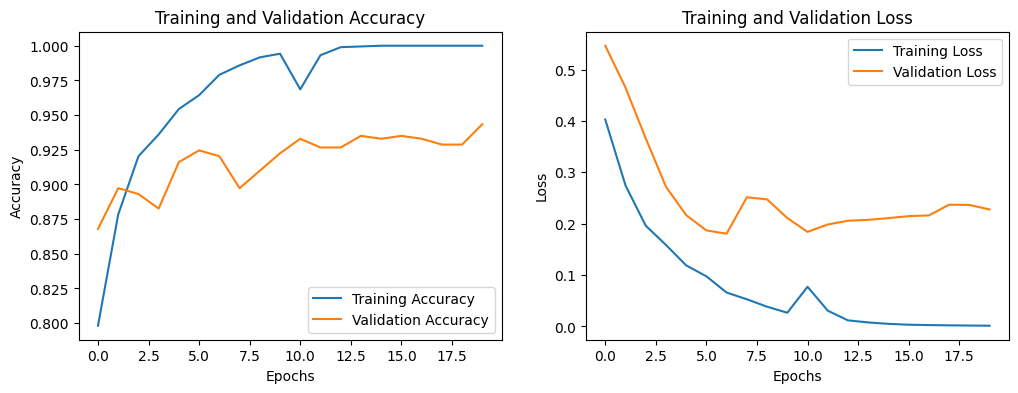

In [141]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9433962264150944
Precision: 0.9434736973634887
FAR: 0.07471264367816093
FRR: 0.0462046204620462


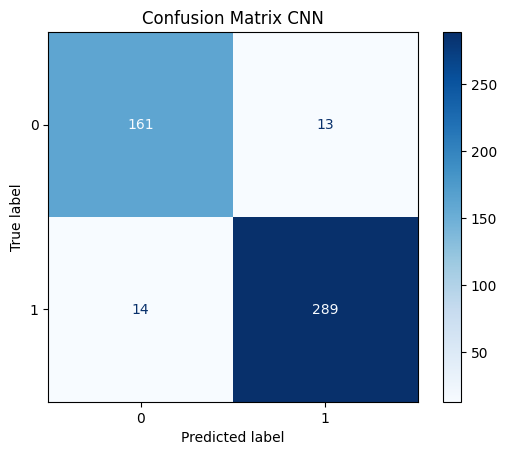

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = (cnnmodel.predict(Xcnn_val) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')  # weighted for multiclass
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
cm = confusion_matrix(y_val, y_pred)
far = cm[0][1]/(cm[0][0]+cm[0][1])
frr = cm[1][0]/(cm[1][0]+cm[1][1])
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"FAR: {far}")
print(f"FRR: {frr}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix CNN")
plt.show()